In [ ]:
import os
import numpy as np 
import pandas as pd 

import sys
import glob
import cv2
import scipy as sp
from tqdm import tqdm
import matplotlib.pyplot as plt
import albumentations

from sklearn.model_selection import StratifiedKFold
import torch
import torch.nn as nn
from torch.optim import Adam, SGD
from torch.optim.lr_scheduler import CosineAnnealingLR, ReduceLROnPlateau
from torch.utils.data import DataLoader, Dataset
import torchvision
import torch.nn.functional as F
from torch.utils.data.sampler import RandomSampler

from albumentations import Compose, Normalize, HorizontalFlip, VerticalFlip
import warnings
warnings.filterwarnings('ignore')


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

BASE_PATH = "/home/ubuntu/cs231nFinalProject/panda_data"
data_folder = os.path.join(BASE_PATH, "image_patches")
masks_path = os.path.join(BASE_PATH, "mask_patches")

all_df = pd.read_csv(os.path.join(BASE_PATH, "filtered_image_patches.csv"))

print(f"Total number of image patches: {len(all_df)}")

images = list(all_df['image_id'])
labels = list(all_df['isup_grade'])

skf = StratifiedKFold(5, shuffle=True, random_state=42)
all_df['fold'] = -1
for i, (train_idx, test_idx) in enumerate(skf.split(all_df, all_df['isup_grade'])):
    # Set up testing fold
    all_df.loc[test_idx, 'fold'] = i


class PandaDataset(Dataset):
    def __init__(self, df, image_size, n_tiles = 36, transforms=None):
        self.df = df.reset_index(drop=True)
        self.image_size = image_size
        self.n_tiles = n_tiles
        self.transform = transforms
    def __len__(self):
        return len(self.df)
    # Custom get item function
    def __getitem__(self, idx):
        if idx > len(self.df):
            idx = len(self.df) - 1
        img_dir_path = os.path.join(data_folder, self.df.iloc[idx]['image_id'])
        mask_dir_path = os.path.join(masks_path, self.df.iloc[idx]['image_id'])
        image_tensors, mask_tensors = [], []
        for i in range(self.n_tiles):
            # Get respective patch and mask
            subscript = "_" + str(i) + ".png"
            ID = self.df.iloc[idx]['image_id'] + subscript
            patch = os.path.join(img_dir_path, ID)
            mask = os.path.join(mask_dir_path, ID)

            # Create Image -> (R, G, B), H, W
            curr_img = cv2.imread(patch)
            curr_img = cv2.cvtColor(curr_img, cv2.COLOR_BGR2RGB)
            curr_img = curr_img.transpose(2,0,1)
            
            # Create Mask -> 1, H, W
            curr_mask = cv2.imread(mask)
            if curr_mask is None:
                curr_mask = np.zeros((1, self.image_size, self.image_size)).astype(np.uint8)
            curr_mask = curr_mask.transpose(2, 0, 1)
            curr_mask = np.max(curr_mask, axis=0)

            image_tensors.append(curr_img)
            mask_tensors.append(curr_mask)

        rows = int(np.sqrt(self.n_tiles))
        # C x H x W
        imgs = np.zeros((3, self.image_size * rows, self.image_size * rows))
        # C x H x W
        masks = np.zeros((self.image_size * rows, self.image_size * rows))
        for h in range(rows):
            for w in range(rows):
                curr_idx = h * rows + w
                curr_img = image_tensors[curr_idx]
                h_scaled = h * self.image_size
                w_scaled = w * self.image_size
                imgs[:, h_scaled : h_scaled + self.image_size, w_scaled : w_scaled + self.image_size] = curr_img
                masks[h_scaled: h_scaled + self.image_size, w_scaled: w_scaled + self.image_size] = curr_mask

        imgs = imgs.astype(np.float64)
        masks = torch.tensor(masks, dtype = torch.float64)
        # Rescale mask if needed
        if self.df.iloc[idx]["data_provider"] == "radboud":
            masks = torch.where(masks <= 1, masks, torch.where(masks <= 2, 1, 2))
        return torch.tensor(imgs), masks, torch.tensor(self.df.iloc[idx]["isup_grade"])
# Create transforms of patches
transforms_train = albumentations.Compose([
    albumentations.VerticalFlip(p=0.5),
    albumentations.HorizontalFlip(p=0.5),
    albumentations.ShiftScaleRotate(scale_limit=0.15, rotate_limit=20, p=0.5)
])

# Load tiles into train/test dataloaders
df_train = all_df.loc[np.where((all_df["fold"] != 0))[0]]
df_test = all_df.loc[np.where((all_df["fold"] == 0))[0]]

# Valid = 0.3 * 0.2 = 0.06%
df_valid = df_test.sample(frac=0.3, random_state=42)
df_test = df_test.drop(df_valid.index)

train_loader = PandaDataset(df_train[79:81], 256, 36, transforms=None)
valid_loader = PandaDataset(df_valid, 256, 36, transforms=None)
test_loader = PandaDataset(df_test, 256, 36, transforms=None)

train_loader = torch.utils.data.DataLoader(train_loader, batch_size=1, sampler=None,
                                            num_workers = 8)
valid_loader = torch.utils.data.DataLoader(valid_loader, batch_size=1, sampler=None,
                                            num_workers = 8)
test_loader = torch.utils.data.DataLoader(test_loader, batch_size=1, sampler=None,
                                            num_workers = 8)

print(f"Number of training batches: {len(train_loader)}")
print(f"Number of valid batches: {len(valid_loader)}")
print(f"Number of testing batches: {len(test_loader)}")

In [ ]:
print(df_train.iloc[50])

In [ ]:
sys.path.append("/home/ubuntu/cs231nFinalProject/src/mtl_exps/mtl_models")

from resnetMTL import MTLWithResnetEncoder
from hiptMTL import MTLHIPT
# Current Model
#mtl = MTLWithResnetEncoder().to(device)
#mtl.load_state_dict(torch.load(os.path.join("/home/ubuntu/cs231nFinalProject/src/mtl_exps/resnet_mtl_final_params.pth")))
#final_conv = mtl.down_blocks[3][2].conv3
#fc_params = list(mtl.class_head_fc1.parameters())


mtl = MTLHIPT().to(device)
mtl.load_state_dict(torch.load(os.path.join("/home/ubuntu/cs231nFinalProject/src/mtl_exps/hipt_mtl4_final_params.pth")))
final_conv = mtl.hipt.model4k.blocks[5].mlp.fc2
fc_params = list(mtl.classify[0].parameters())


In [ ]:
# Code adapted from Grad-CAM implementation
class SaveFeatures():
    """ Extract pretrained activations"""
    features = None
    def __init__(self, m):
        self.hook = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output):
        self.features = ((output.cpu()).data).numpy()
    def remove(self):
        self.hook.remove()

def getCAM(feature_conv, weight_fc, class_idx):
    _, C, H, W = feature_conv.shape
    cam = weight_fc[class_idx].dot(feature_conv[0,:, :, ].reshape((C, H*W)))
    cam = cam.reshape(H, W)
    cam = cam - np.min(cam)
    cam_img = cam / np.max(cam)
    return cam_img

def plotGradCAM(model, final_conv, fc_params, loader, rows=1, cols=2, img_size=256, device=device):
    for param in model.parameters():
        param.requires_grad = False
    model.to(device)
    model.eval()
    # save activated_features from conv
    activated_features = SaveFeatures(final_conv)
    # save weight from fc
    fc_weight = np.squeeze(fc_params[0].cpu().data.numpy())
    # Plot original image
    fig = plt.figure(figsize=(20, 15))
    pred_idx = None
    start = 1
    for i, (img, _, target) in enumerate(loader):
        # Get a single image
        output, _ = model(img.to(device, dtype=torch.float))
        pred_idx = output.to('cpu').numpy().argmax(1)
        cur_image = (torch.transpose(img.cpu(), 1, 3).numpy().astype(np.float32)) / 255
        ax = fig.add_subplot(rows, cols, i + 1, xticks=[], yticks=[])
        plt.imshow(cur_image[0])
        ax.set_title('Original grading:%d, Grading prediction:%d' % (target, pred_idx), fontsize=14)        
        if i == cols - 1:
            break
            
    plt.show()
    fig = plt.figure(figsize=(20,15))
    for i, (img, _, target) in enumerate(loader):
        # Get a single image
        output, _ = model(img.to(device, dtype=torch.float))
        pred_idx = output.to('cpu').numpy().argmax(1)
        heatmap = getCAM(activated_features.features, fc_weight, pred_idx)
        ax = fig.add_subplot(rows, cols, i + 1, xticks=[], yticks=[])
        plt.imshow(cv2.resize(heatmap, (img_size, img_size), interpolation=cv2.INTER_LINEAR), alpha=0.4, cmap='jet')
        if i == cols - 1:
            break
    plt.show()

In [ ]:
plotGradCAM(mtl, final_conv, fc_params, train_loader, img_size=1536, device=device)

In [ ]:
plotGradCAM(resnet, final_conv, fc_params, train_loader, img_size=1536, device=device)

In [ ]:
img_dir_path = os.path.join(data_folder, "06a0cbd8fd6320ef1aa6f19342af2e68")
mask_dir_path = os.path.join(masks_path, "06a0cbd8fd6320ef1aa6f19342af2e68")
image_tensors, mask_tensors = [], []
for i in range(36):
    # Get respective patch and mask
    subscript = "_" + str(i) + ".png"
    ID = "06a0cbd8fd6320ef1aa6f19342af2e68" + subscript
    patch = os.path.join(img_dir_path, ID)
    mask = os.path.join(mask_dir_path, ID)

    # Create Image -> (R, G, B), H, W
    curr_img = cv2.imread(patch)
    curr_img = cv2.cvtColor(curr_img, cv2.COLOR_BGR2RGB)
    curr_img = curr_img.transpose(2,0,1)

    # Create Mask -> 1, H, W
    curr_mask = cv2.imread(mask)
    if curr_mask is None:
        curr_mask = np.zeros((1, 256, 256)).astype(np.uint8)
    curr_mask = curr_mask.transpose(2, 0, 1)
    curr_mask = np.max(curr_mask, axis=0)

    image_tensors.append(curr_img)
    mask_tensors.append(curr_mask)

rows = 6
# C x H x W
imgs = np.zeros((3, 256 * rows, 256 * rows))
# H x W
masks = np.zeros((256 * rows, 256 * rows))
for h in range(6):
    for w in range(6):
        curr_idx = h * rows + w
        curr_img = image_tensors[curr_idx]
        if len(mask_tensors) < curr_idx:
            curr_mask = np.zeros((256, 256)).astype(np.uint8)
        else:
            curr_mask = mask_tensors[curr_idx]
        h_scaled = h * 256
        w_scaled = w * 256
        imgs[:, h_scaled : h_scaled + 256, w_scaled : w_scaled + 256] = curr_img
        masks[h_scaled: h_scaled + 256, w_scaled: w_scaled + 256] = curr_mask

imgs = imgs.astype(np.float64) / 255
masks = torch.tensor(masks, dtype = torch.float64)
# Rescale mask if needed
masks = torch.where(masks <= 1, masks, torch.where(masks <= 2, 1, 2))

save_image(torch.tensor(imgs), '/home/ubuntu/cs231nFinalProject/src/gradcam_viz/sam_image2.jpg')

In [ ]:
import sys

sys.path.append("/home/ubuntu/cs231nFinalProject/src/UNet")

from UNet import UNet

unet = UNet().to(device)
unet_model_weights = "/home/ubuntu/cs231nFinalProject/src/UNet/custom_unet_model_epoch_4.pth"
unet.load_state_dict(torch.load(unet_model_weights))
unet.eval()


fig = plt.figure(figsize=(15,10))
j = 0
for i, (img, mask, target) in enumerate(train_loader):
    pred = unet(img.to(device, dtype=torch.float))
    pred = torch.argmax(pred, dim=1).squeeze(1).type(torch.long)
    pred = pred.to('cpu').detach().numpy()
    mask = mask.detach().numpy()[0]
    
    #pred_norm = cv2.normalize(pred[0], None, 0, 2, cv2.NORM_MINMAX)
    #mask_norm = cv2.normalize(mask[0], None, 0, 2, cv2.NORM_MINMAX)
    ax = fig.add_subplot(2, 2, i + 1, xticks=[], yticks=[])
    plt.imshow(mask)
    ax.set_title('Ground truth segmentation', fontsize=14)        
    ax = fig.add_subplot(2, 2, i + 3, xticks=[], yticks=[])
    ax.set_title('Predicted segmentation mask', fontsize=14)
    plt.imshow(pred[0])

In [ ]:
plotGradCAM(resnet, final_conv, fc_params, train_loader, img_size=1536, device=device)

In [1]:
import os as os
import cv2 
import torch
import numpy as np

In [2]:
def apply_random_transform(image):
    # Randomly select transformation parameters
    flip_vertical = np.random.choice([True, False, True])
    flip_horizontal = np.random.choice([True, False])
    blur = np.random.choice([True, False, False])
    angle = np.random.uniform(-30, 30)
    scale = np.random.uniform(0.8, 1.2)
    tx = np.random.uniform(-20, 20)
    ty = np.random.uniform(-20, 20)

    # Perform the transformations
    if flip_vertical:
        image = cv2.flip(image, 0)
    if flip_horizontal:
        image = cv2.flip(image, 1)
        
    if blur:
        image = cv2.GaussianBlur(image, (0, 0), sigmaX=3)


    rows, cols, _ = image.shape

    return image

In [3]:
def getitem():
        # print("Get Item Called")
        # Get Image and Mask Directories
        img_dir_path = "../../panda_data/image_patches/6b4c77b671e8412d65773f9614816db0"
        mask_dir_path = "../../panda_data/mask_patches/6b4c77b671e8412d65773f9614816db0"

        # Collect
        image_tensors = []
        mask_tensors = []

        for i in range(36):
            # Get respective patch and mask
            subscript = "_" + str(i) + ".png"
            ID = "6b4c77b671e8412d65773f9614816db0" + subscript
            patch = os.path.join(img_dir_path, ID)
            mask = os.path.join(mask_dir_path, ID)

            # Create Image -> (R, G, B), H, W
            curr_img = cv2.imread(patch)
            curr_img = cv2.cvtColor(curr_img, cv2.COLOR_BGR2RGB)
            curr_img = curr_img.transpose(2,0,1)

            # Create Mask -> 1, H, W
            curr_mask = cv2.imread(mask)
            curr_mask = curr_mask.transpose(2, 0, 1)
            curr_mask = np.max(curr_mask, axis=0)
            

            image_tensors.append(torch.tensor(curr_img).float())
            mask_tensors.append(torch.tensor(curr_mask))

        # Create Big Tensor -> C x 36 x H x W
        imgs = torch.zeros((3, 1536, 1536)).float()
        masks = torch.zeros((1536, 1536))

        for i in range(6):
            for j in range(6):
                imgs[:, 256 * i : 256 * (i + 1), 256 * j : 256 * (j + 1)] = image_tensors[i * 6 + j]
                masks[256 * i : 256 * (i + 1), 256 * j : 256 * (j + 1)] = mask_tensors[i * 6 + j]

        assert torch.equal(masks[256:512, 768:1024], mask_tensors[9])


        masks = torch.where(masks <= 1, masks, torch.where(masks <= 2, 1, 2))

        return imgs, masks

In [25]:
imgs, masks = getitem()

In [ ]:
import albumentations
transforms_train = albumentations.Compose([
    albumentations.VerticalFlip(p=0.5),
    albumentations.HorizontalFlip(p=0.5),
    albumentations.ShiftScaleRotate(scale_limit=0.15, rotate_limit=20, p=0.5)
])

augmentations = transforms_train(image=imgs)
imgs = augmentations["image"]

In [5]:
import numpy as np
from PIL import Image
import torch
import matplotlib.pyplot as plt

In [26]:
imgs = imgs.transpose(0, 2)

In [27]:
image_array = imgs.numpy()
image_array.shape
image_array = image_array.astype(int)

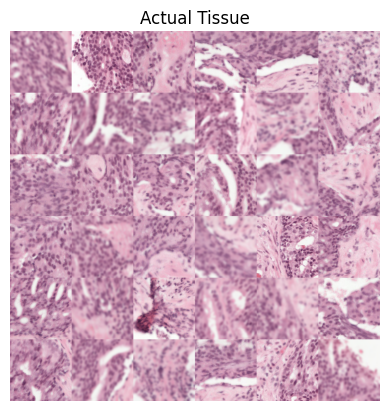

In [29]:
plt.figure()
plt.imshow(image_array)
plt.axis('off')
plt.title('Actual Tissue')

plt.show()

In [9]:
torch.max(masks)

tensor(2.)

In [10]:
masks = masks.numpy()

In [11]:
print(masks)

[[1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 ...
 [2. 2. 2. ... 2. 2. 2.]
 [2. 2. 2. ... 2. 2. 2.]
 [2. 2. 2. ... 2. 2. 2.]]


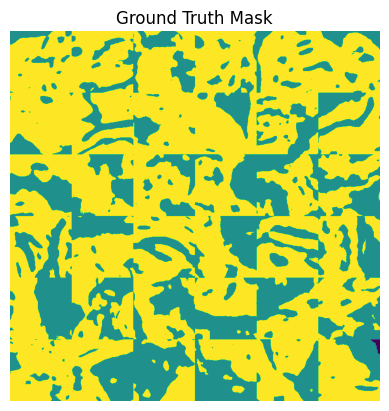

In [30]:
plt.figure()
plt.imshow(masks, cmap='viridis')
plt.axis('off')
plt.title('Ground Truth Mask')

plt.show()

In [ ]:
import sys
sys.path.append("/home/ubuntu/cs231nFinalProject/src/mtl_exps/mtl_models")
from hiptMTL import MTLHIPT


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [13]:
import sys
sys.path.append("/home/ubuntu/cs231nFinalProject/src/UNet")
from UNet import UNet
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

mtl = UNet().to(device)
mtl.load_state_dict(torch.load("/home/ubuntu/cs231nFinalProject/src/UNet/custom_unet_model_epoch_4.pth"))

<All keys matched successfully>

In [ ]:
mtl = MTLHIPT().to(device)
mtl.load_state_dict(torch.load("/home/ubuntu/cs231nFinalProject/src/mtl_exps/hipt_mtl4_final_params.pth"))

In [14]:
mtl.eval()

UNet(
  (down_path): ModuleList(
    (0): UNetConvBlock(
      (block): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU()
        (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): ReLU()
        (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): UNetConvBlock(
      (block): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU()
        (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): ReLU()
        (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): UNetConvBlock(
      (block): Sequential(
        (0): C

In [15]:
imgs = imgs.unsqueeze(0).transpose(1, 3).to(device)

In [16]:
imgs.shape

torch.Size([1, 3, 1536, 1536])

In [17]:
out = mtl(imgs)

In [18]:
out

tensor([[[[-0.5903, -0.4412, -0.4993,  ..., -0.5875, -0.7470, -0.1760],
          [-0.7817, -0.9565, -0.7029,  ..., -1.0893, -1.2470, -0.5466],
          [-0.7330, -0.9537, -1.3483,  ..., -1.3575, -1.4679, -0.3868],
          ...,
          [-0.8315, -0.5887, -0.7734,  ..., -0.6846, -0.6696,  0.0831],
          [-0.5275, -0.4553, -0.7451,  ..., -0.4626, -0.1591,  0.3319],
          [ 0.0841, -0.5265, -0.4963,  ...,  0.0906,  0.1223,  0.4668]],

         [[-0.0082,  0.6474,  0.5972,  ...,  1.2819,  1.1501, -0.3679],
          [ 0.7630,  0.8768,  0.8724,  ...,  1.5967,  1.2472,  0.0718],
          [ 1.3525,  1.2343,  1.3372,  ...,  1.6434,  1.1942, -0.2352],
          ...,
          [ 0.7537,  1.2912,  1.7501,  ..., -0.3485, -0.5442, -0.9500],
          [ 0.1248,  0.2506,  0.5691,  ..., -1.2523, -1.3510, -1.1341],
          [-0.4768, -0.2342, -0.0244,  ..., -0.9071, -0.6590, -1.0017]],

         [[-0.5765, -0.2043, -0.3663,  ...,  0.0765,  0.0038, -0.8238],
          [-0.6175, -0.4422, -

In [19]:
mask_logits = out

In [20]:
mask_logits.shape

torch.Size([1, 3, 1536, 1536])

In [21]:
segment_preds = torch.argmax(mask_logits, dim=1).squeeze(1).type(torch.long)

In [22]:
segment_preds

tensor([[[1, 1, 1,  ..., 1, 1, 0],
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         ...,
         [1, 1, 1,  ..., 1, 1, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [0, 1, 1,  ..., 0, 0, 0]]], device='cuda:0')

In [23]:
mask = segment_preds.cpu().numpy()
mask = mask[0, :, :]

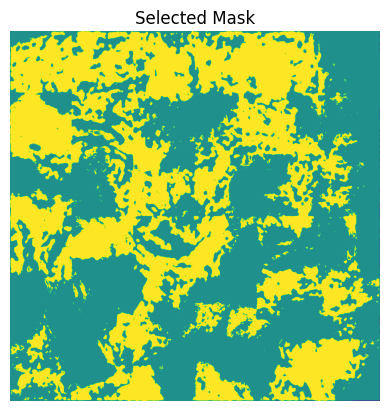

In [24]:
plt.figure()
plt.imshow(mask, cmap='viridis')
plt.axis('off')
plt.title(' Mask')

plt.show()

In [ ]:
import torch.nn.functional as F
import torchvision

import albumentations
transforms_train = albumentations.Compose([
    albumentations.ShiftScaleRotate(scale_limit=0.15, rotate_limit=2, p=1.0)
])

In [ ]:
masks = masks.astype(np.uint8)
masks

In [ ]:
out = transforms_train(image=masks)

In [ ]:
curr_mask = masks

In [ ]:
x, y = masks.shape
import random

for i in range(x):
    for j in range(y):
        p = random.uniform(0, 1)
        
        if p < 0.8:
            curr_mask[i][j] = random.choice([0, 1, 2])

In [ ]:
plt.figure()
plt.imshow(curr_mask, cmap='viridis')
plt.axis('off')
plt.title('Selected Mask')

plt.show()

In [ ]:
scaled_array = mask.astype(float)  # Convert to float for intensity scaling

# Define a custom colormap with 3 colors for intensity values 0, 1, and 2
cmap = plt.cm.colors.ListedColormap(['black', 'blue', 'white'])
bounds = [0, 1, 2]  # Color boundaries
norm = plt.cm.colors.BoundaryNorm(bounds, cmap.N)  # Normalize the color boundaries

# Create a figure and axes
fig, ax = plt.subplots()

# Display the image
ax.imshow(scaled_array, cmap=cmap, norm=norm)

# Remove the axis labels
ax.axis('off')

# Show the plot
plt.show()